# NR Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import sys
import random as rd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as tud
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import CustomDataset as cd

### Loading Data

First, I'm going to try to distinguish between Carbon 130keV and Flourine 170keV.

In [2]:
C130_dat, F170_dat = np.load('data/C_130keV_10000.npy'), np.load('data/F_170keV_10000.npy')

In [3]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))


Accuracy Possible with Cut of 2096 on Total Intensity: 93.67%


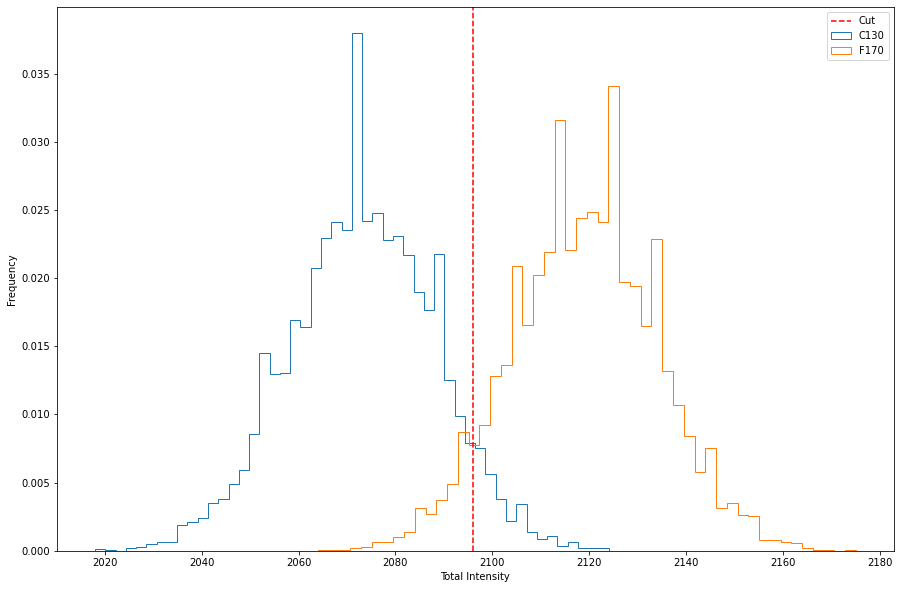

In [4]:
cut = 2096
Cless, Fgrt = [],[]
for i in range(len(Fsum)):
    if Fsum[i] > cut:
        Fgrt.append(Fsum[i])
    if Csum[i] <= cut:
        Cless.append(Csum[i])

plt.figure(figsize=(15,10))
plt.hist(Csum, density=True, histtype='step', bins=50, label='C130')  # density=False would make counts
plt.hist(Fsum, density=True, histtype='step', bins=50, label='F170')
plt.axvline(cut, c='r', ls='--', label='Cut')
plt.ylabel('Frequency')
plt.xlabel('Total Intensity')
plt.legend()
plt.savefig('intensity_hist.png')

Acc = (len(Fgrt)+len(Cless))/(len(Fsum)+len(Csum))*100
print('\nAccuracy Possible with Cut of {} on Total Intensity: {}%'.format(cut,Acc))

The above accuracy is a target.

For a learning algorithm, it will be necesarry to have an input (X data) containing a number of $97\times97$ matrices for each energy. The output will be a label, either Carbon or Flourine. The model will compare its output with the actual labels and adjust accordingly to minimise loss. 

In order to quantify each label, the common 'one-hot encoding' method will be used. C elements will have the label `[1, 0]` and F will be `[0, 1]`. Tuples of this form will be the ground truth labels and the model output. I will have to ensure that the model outputs an array of shape `[2]`.

In [55]:
def dataprep(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
    xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
    print(xtrain_sqz.shape)

    ytrain_tensor = torch.from_numpy(np.array(y_train))
    ytrain_sqz = ytrain_tensor.unsqueeze(1)
    print(ytrain_sqz.shape)

    xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
    xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
    print(xtest_sqz.shape)

    ytest_tensor = torch.from_numpy(np.array(y_test))
    ytest_sqz = ytest_tensor.unsqueeze(1)
    print(ytest_sqz.shape)

    train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_sqz.float())
    test_data = cd.CustomDataset(xtest_sqz.float(), ytest_sqz.float())

    #defining dataloader class
    train_loader = tud.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
    train_loader_iter = iter(train_loader)

    #same as above but for test data
    test_loader = tud.DataLoader(dataset=test_data, batch_size=50, shuffle=True)
    test_loader_iter = iter(test_loader)
    
    return train_loader, test_loader

In [56]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    #loop run over data output by loader to train model
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data) #applies model to data
        target = target.squeeze(1) #removes dimension from target
        loss = nn.CrossEntropyLoss()(output, target) #calculates cross entropy loss
        loss.backward()
        optimizer.step() #new step in optimisation of loss
        #printing output of each batch for loss observation while model is training
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    #initialisting parameters and empty lists
    test_loss = 0
    correct = 0
    probs_pred = []
    labels_actual = []
    labels_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target=target.squeeze(1)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
        
            pred = output.max(1, keepdim=True)[1] #finds index of maximum in output vector as described below
            pred_onehot = F.one_hot(pred).squeeze(1) #converts into one-hot predicted label 
            pred_bool = torch.eq(pred_onehot,target) #finds values where predicted equals target
            correct += int((pred_bool.sum().item())/2) #sums number of correct values
            #adds predicted labels, targets and probabilities to lists for later use
            
            labels_actual.append(target.cpu().numpy())
            probs_pred.append(output.cpu().numpy())
            labels_pred.append(pred_onehot.cpu().numpy())
 
    #printing accuracy and loss after each epoch for analysis
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100 * correct / len(test_loader.dataset)))
    
    return(labels_actual,probs_pred,labels_pred)

### Model 

In [57]:
inp = torch.randn(50, 1, 97, 97)
m = nn.Conv2d(1, 5, kernel_size=(2,2))
o = m(inp)
print(np.shape(o))
m = nn.Conv2d(5, 10, kernel_size=(2,2))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(10, 15, kernel_size=(2,2))
o = m(o)
print(np.shape(o))

o = o.view(-1, 132540)
print(np.shape(o))
m = nn.Linear(132540,500)
o = m(o)
print(np.shape(o))
m = nn.Linear(500,2)
o = m(o)
print(np.shape(o))

torch.Size([50, 5, 96, 96])
torch.Size([50, 10, 95, 95])
torch.Size([50, 15, 94, 94])
torch.Size([50, 132540])
torch.Size([50, 500])
torch.Size([50, 2])


In [58]:
94*94*15

132540

In [59]:
device = torch.device('cuda')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            
        self.fc_layers = nn.Sequential(
            nn.Linear(9409,2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 9409)
        x = self.fc_layers(x)
        return x

In [60]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [61]:
#outputting variables from initial model
initial_model = model
numel_list = [p.numel() for p in model.parameters()]

In [62]:
train_loader, test_loader = dataprep(data,labels)

torch.Size([16000, 1, 97, 97])
torch.Size([16000, 1, 2])
torch.Size([4000, 1, 97, 97])
torch.Size([4000, 1, 2])


In [63]:
num_epochs = 10 #setting number of epochs for CNN
batch_size= 50

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 1 [0/16000 (0%)]	Loss: 0.678525
Train Epoch: 1 [2500/16000 (16%)]	Loss: 0.638338
Train Epoch: 1 [5000/16000 (31%)]	Loss: 0.726858
Train Epoch: 1 [7500/16000 (47%)]	Loss: 0.711507
Train Epoch: 1 [10000/16000 (62%)]	Loss: 0.682511
Train Epoch: 1 [12500/16000 (78%)]	Loss: 0.680711
Train Epoch: 1 [15000/16000 (94%)]	Loss: 0.710791

Test set: Average loss: 0.0137, Accuracy: 2198/4000 (55%)

Train Epoch: 2 [0/16000 (0%)]	Loss: 0.682677
Train Epoch: 2 [2500/16000 (16%)]	Loss: 0.681026
Train Epoch: 2 [5000/16000 (31%)]	Loss: 0.696584
Train Epoch: 2 [7500/16000 (47%)]	Loss: 0.652466
Train Epoch: 2 [10000/16000 (62%)]	Loss: 0.642440
Train Epoch: 2 [12500/16000 (78%)]	Loss: 0.697816
Train Epoch: 2 [15000/16000 (94%)]	Loss: 0.649101

Test set: Average loss: 0.0137, Accuracy: 2183/4000 (55%)

Train Epoch: 3 [0/16000 (0%)]	Loss: 0.640546
Train Epoch: 3 [2500/16000 (16%)]	Loss: 0.649729
Train Epoch: 3 [5000/16000 (31%)]	Loss: 0.686415
Train Epoch: 3 [7500/16000 (47%)]	Loss: 0.767900
Trai

### All Models Tested and Observations

#### Model 1

In [ ]:
inp = torch.randn(50, 1, 97, 97)
m1 = nn.Conv2d(1, 1, kernel_size=(12,12))
o1 = m1(inp)
print(np.shape(o1))
m2 = nn.MaxPool2d(kernel_size=(2,2))
o2 = m2(o1)
print(np.shape(o2))

o3 = o2.view(-1, 1849)
print(np.shape(o3))
m4 = nn.Linear(1849,500)
o4 = m4(o3)
print(np.shape(o4))
m5 = nn.Linear(500,50)
o5 = m5(o4)
print(np.shape(o5))
m6 = nn.Linear(50,2)
o6 = m6(o5)
print(np.shape(o6))

Accuracies around 65%

Tried Sigmoid, Softmax and ReLU as final activation function. Sigmoid marginally better than Softmax. ReLU doesn't work at all.

#### Model 2

In [ ]:
inp = torch.randn(50, 1, 97, 97)
m = nn.Conv2d(1, 1, kernel_size=(5,5), padding = 2)
o = m(inp)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(3,3))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(1, 1, kernel_size=(5,5), padding = 2)
o = m(o)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(2,2))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(1, 1, kernel_size=(3,3), padding = 1)
o = m(o)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(2,2))
o = m(o)
print(np.shape(o))


o = o.view(-1, 64)
print(np.shape(o3))
m = nn.Linear(64,20)
o = m(o)
print(np.shape(o))
m = nn.Linear(20,2)
o = m(o)
print(np.shape(o))

Accuracies around 60%. Tried changing the learning rate but to no real effect.

Get rid of max pooling?

Small network, 2/4 channels.

Try just 1/2 linear layers. Add bias, tanh().

#### Model 3

In [ ]:
inp = torch.randn(50, 1, 97, 97)
m = nn.Conv2d(1, 3, kernel_size=(5,5), padding = 2)
o = m(inp)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(3,3))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(3, 3, kernel_size=(5,5), padding = 2)
o = m(o)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(2,2))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(3, 5, kernel_size=(3,3), padding = 1)
o = m(o)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(2,2))
o = m(o)
print(np.shape(o))


o = o.view(-1, 320)
print(np.shape(o3))
m = nn.Linear(320,20)
o = m(o)
print(np.shape(o))
m = nn.Linear(20,2)
o = m(o)
print(np.shape(o))

Accuracy of 68%

#### Model 4

In [ ]:
inp = torch.randn(50, 1, 97, 97)
m = nn.Conv2d(1, 3, kernel_size=(5,5), padding = 2)
o = m(inp)
print(np.shape(o))


o = o.view(-1, 28227)
m = nn.Linear(28227,20)
o = m(o)
print(np.shape(o))
m = nn.Linear(20,2)
o = m(o)
print(np.shape(o))

Accuracy of 60%

#### Model 5

In [ ]:
inp = torch.randn(50, 1, 97, 97)

o = inp.view(-1, 9409)
m = nn.Linear(9409,2)
o = m(o)
print(np.shape(o))

Accuracy of 51%

Perhaps many channels CNN necessary.